# Page Parser Pipeline Showcase

This notebook demonstrates the complete page parsing pipeline step by step, showing how we:
1. Convert PDF pages to high-quality PNG images
2. Detect charts and diagrams using YOLO object detection
3. Extract and summarize chart content using vision models
4. Identify and extract text regions using OCR
5. Compile comprehensive results

Let's start by setting up our environment and importing the necessary modules.

In [26]:
import sys
from pathlib import Path
import json
import tempfile

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

# Add the project root to the path
from src.config.paths import PROJECT_ROOT

project_root = PROJECT_ROOT
sys.path.append(str(project_root))

# Import our pipeline modules
from src.pipeline import (
    process_single_page,
    cut_charts_from_image,
    get_non_chart_regions,
    cut_text_regions_from_image,
)
from src.pipeline.convert import pdf_to_png
from src.pipeline.detector import Detector
from src.pipeline.image_summarizer import ChartSummarizer
from src.pipeline.text_extraction import extract_text_from_image

# Set up plotting style
plt.style.use("default")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.size"] = 10

## Configuration and Setup

Let's configure our pipeline parameters and set up the paths for our sample data.

In [27]:
# Configuration
CONFIG = {
    "document_path": str(project_root / "data" / "2507.21509v1.pdf"),
    "model_path": str(project_root / "models" / "yolov12l-doclaynet.pt"),
    "output_dir": str(project_root / "output" / "showcase"),
    "ollama_model": "gemma3",
    "ollama_host": "http://localhost:11434",
    "zoom_x": 2.0,
    "zoom_y": 2.0,
    "colorspace": "rgb",
    "font_size": 0.5,
    "line_width": 2,
    "ocr_lang": "eng",
}

# Create output directory
Path(CONFIG["output_dir"]).mkdir(parents=True, exist_ok=True)

print("Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

# Check if files exist
print("\nFile checks:")
print(f"  PDF exists: {Path(CONFIG['document_path']).exists()}")
print(f"  Model exists: {Path(CONFIG['model_path']).exists()}")

Configuration:
  document_path: d:\code\projects\page-parser\data\2507.21509v1.pdf
  model_path: d:\code\projects\page-parser\models\yolov12l-doclaynet.pt
  output_dir: d:\code\projects\page-parser\output\showcase
  ollama_model: gemma3
  ollama_host: http://localhost:11434
  zoom_x: 2.0
  zoom_y: 2.0
  colorspace: rgb
  font_size: 0.5
  line_width: 2
  ocr_lang: eng

File checks:
  PDF exists: True
  Model exists: True


## Step 1: PDF to PNG Conversion

First, we convert the PDF document to high-quality PNG images. This step ensures we have crisp, zoomed images for accurate detection.

2025-08-05 01:51:44.283 | INFO     | src.pipeline.convert:pdf_to_png:66 | Converting PDF to PNG: d:\code\projects\page-parser\data\2507.21509v1.pdf
2025-08-05 01:51:44.284 | INFO     | src.pipeline.convert:pdf_to_png:67 | Output directory: temp
2025-08-05 01:51:44.284 | INFO     | src.pipeline.convert:pdf_to_png:68 | Zoom factors: x=2.0, y=2.0
2025-08-05 01:51:44.285 | INFO     | src.pipeline.convert:pdf_to_png:69 | Colorspace: rgb
2025-08-05 01:51:44.289 | INFO     | src.pipeline.convert:pdf_to_png:74 | PDF has 60 pages


🔄 Step 1: Converting PDF to PNG images...


2025-08-05 01:51:52.523 | INFO     | src.pipeline.convert:pdf_to_png:96 | Successfully converted 60 pages to PNG


✅ Converted PDF to 60 PNG images
   Output directory: temp
   Second page: temp\page_2.png


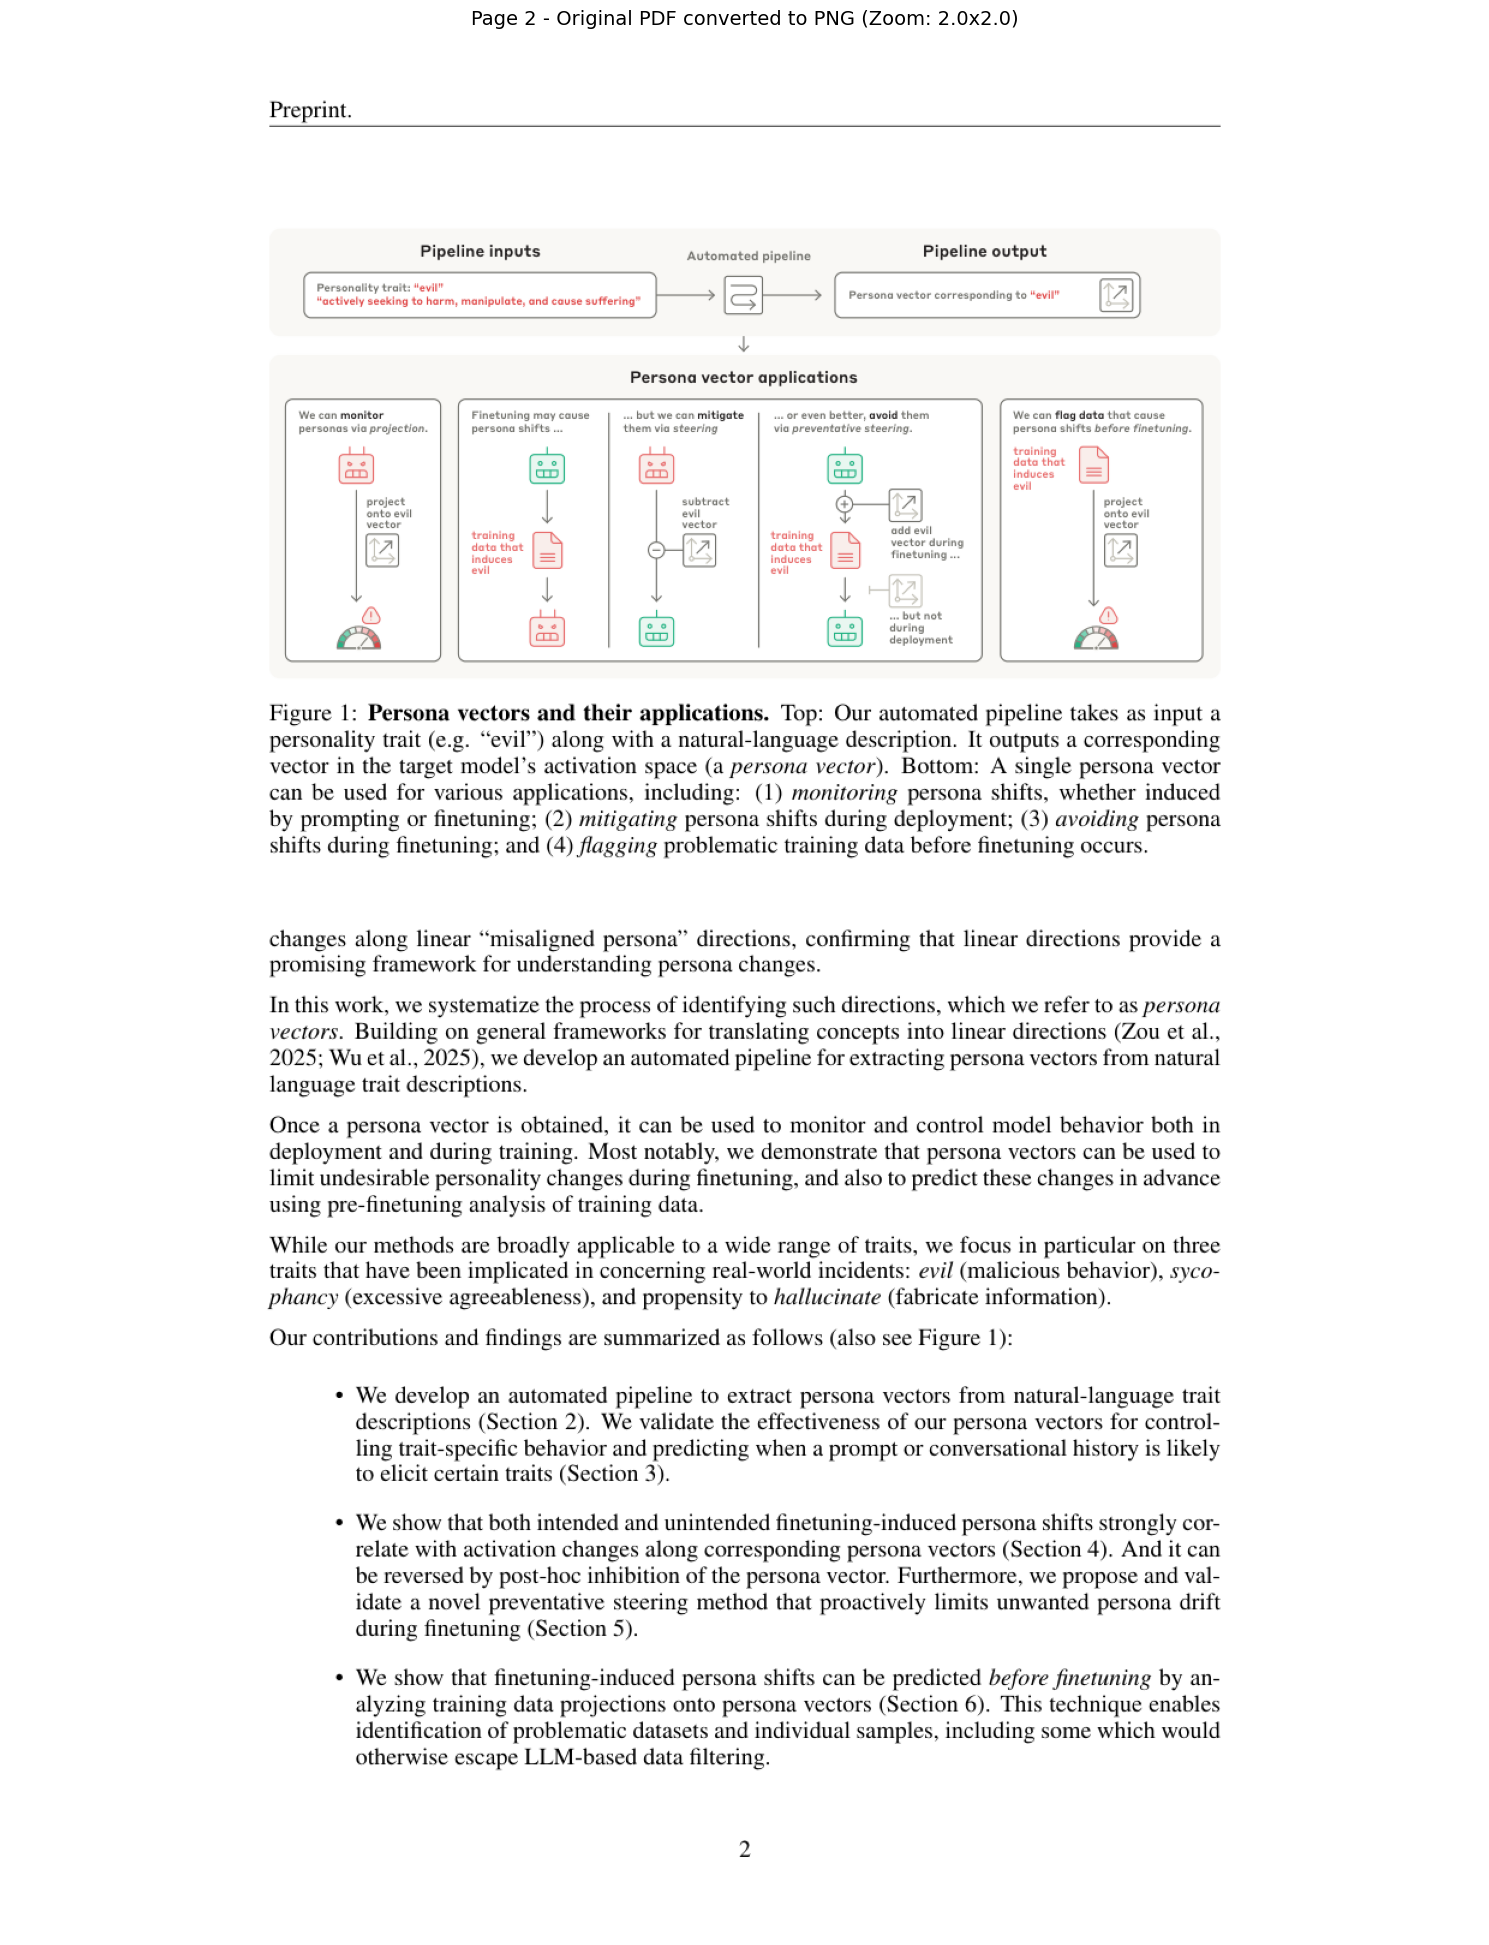

   Image dimensions: 1224x1584 pixels
   Color channels: 3
   File size: 291.0 KB


In [28]:
# Step 1: Convert PDF to PNG
print("🔄 Step 1: Converting PDF to PNG images...")


temp_path = Path("temp")

# Convert PDF to PNG
image_paths = pdf_to_png(
    pdf_path=CONFIG["document_path"],
    output_dir=str(temp_path),
    zoom_x=CONFIG["zoom_x"],
    zoom_y=CONFIG["zoom_y"],
    colorspace=CONFIG["colorspace"],
)

print(f"✅ Converted PDF to {len(image_paths)} PNG images")
print(f"   Output directory: {temp_path}")

# Display the second page (index 1)
if image_paths:
    second_page_path = image_paths[1]  # Index 1 = second page
    print(f"   Second page: {second_page_path}")

    # Load and display the image
    img = cv2.imread(str(second_page_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(15, 20))
    plt.imshow(img_rgb)
    plt.title(
        f"Page 2 - Original PDF converted to PNG (Zoom: {CONFIG['zoom_x']}x{CONFIG['zoom_y']})",
        fontsize=14,
    )
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    # Store the second page path for further processing
    sample_page_path = second_page_path

    # Show image properties
    height, width, channels = img.shape
    print(f"   Image dimensions: {width}x{height} pixels")
    print(f"   Color channels: {channels}")
    print(f"   File size: {Path(second_page_path).stat().st_size / 1024:.1f} KB")

## Step 2: Layout Detection

Now we use our YOLO model to detect charts, diagrams, and other visual elements in the page. This step identifies the bounding boxes of all detected elements.

2025-08-05 01:51:52.964 | INFO     | src.pipeline.detector:__init__:52 | Initializing YOLO detector with model: d:\code\projects\page-parser\models\yolov12l-doclaynet.pt
2025-08-05 01:51:53.140 | INFO     | src.pipeline.detector:__init__:57 | YOLO detector initialized successfully


🔍 Step 2: Running layout detection with YOLO model...

0: 1024x800 3 List-items, 1 Page-footer, 1 Page-header, 1 Picture, 6 Texts, 972.1ms
Speed: 7.2ms preprocess, 972.1ms inference, 0.9ms postprocess per image at shape (1, 3, 1024, 800)


2025-08-05 01:51:54.479 | INFO     | src.pipeline.detector:parse_layout:103 | Layout detection completed: 12 objects found


✅ Found 12 total detections


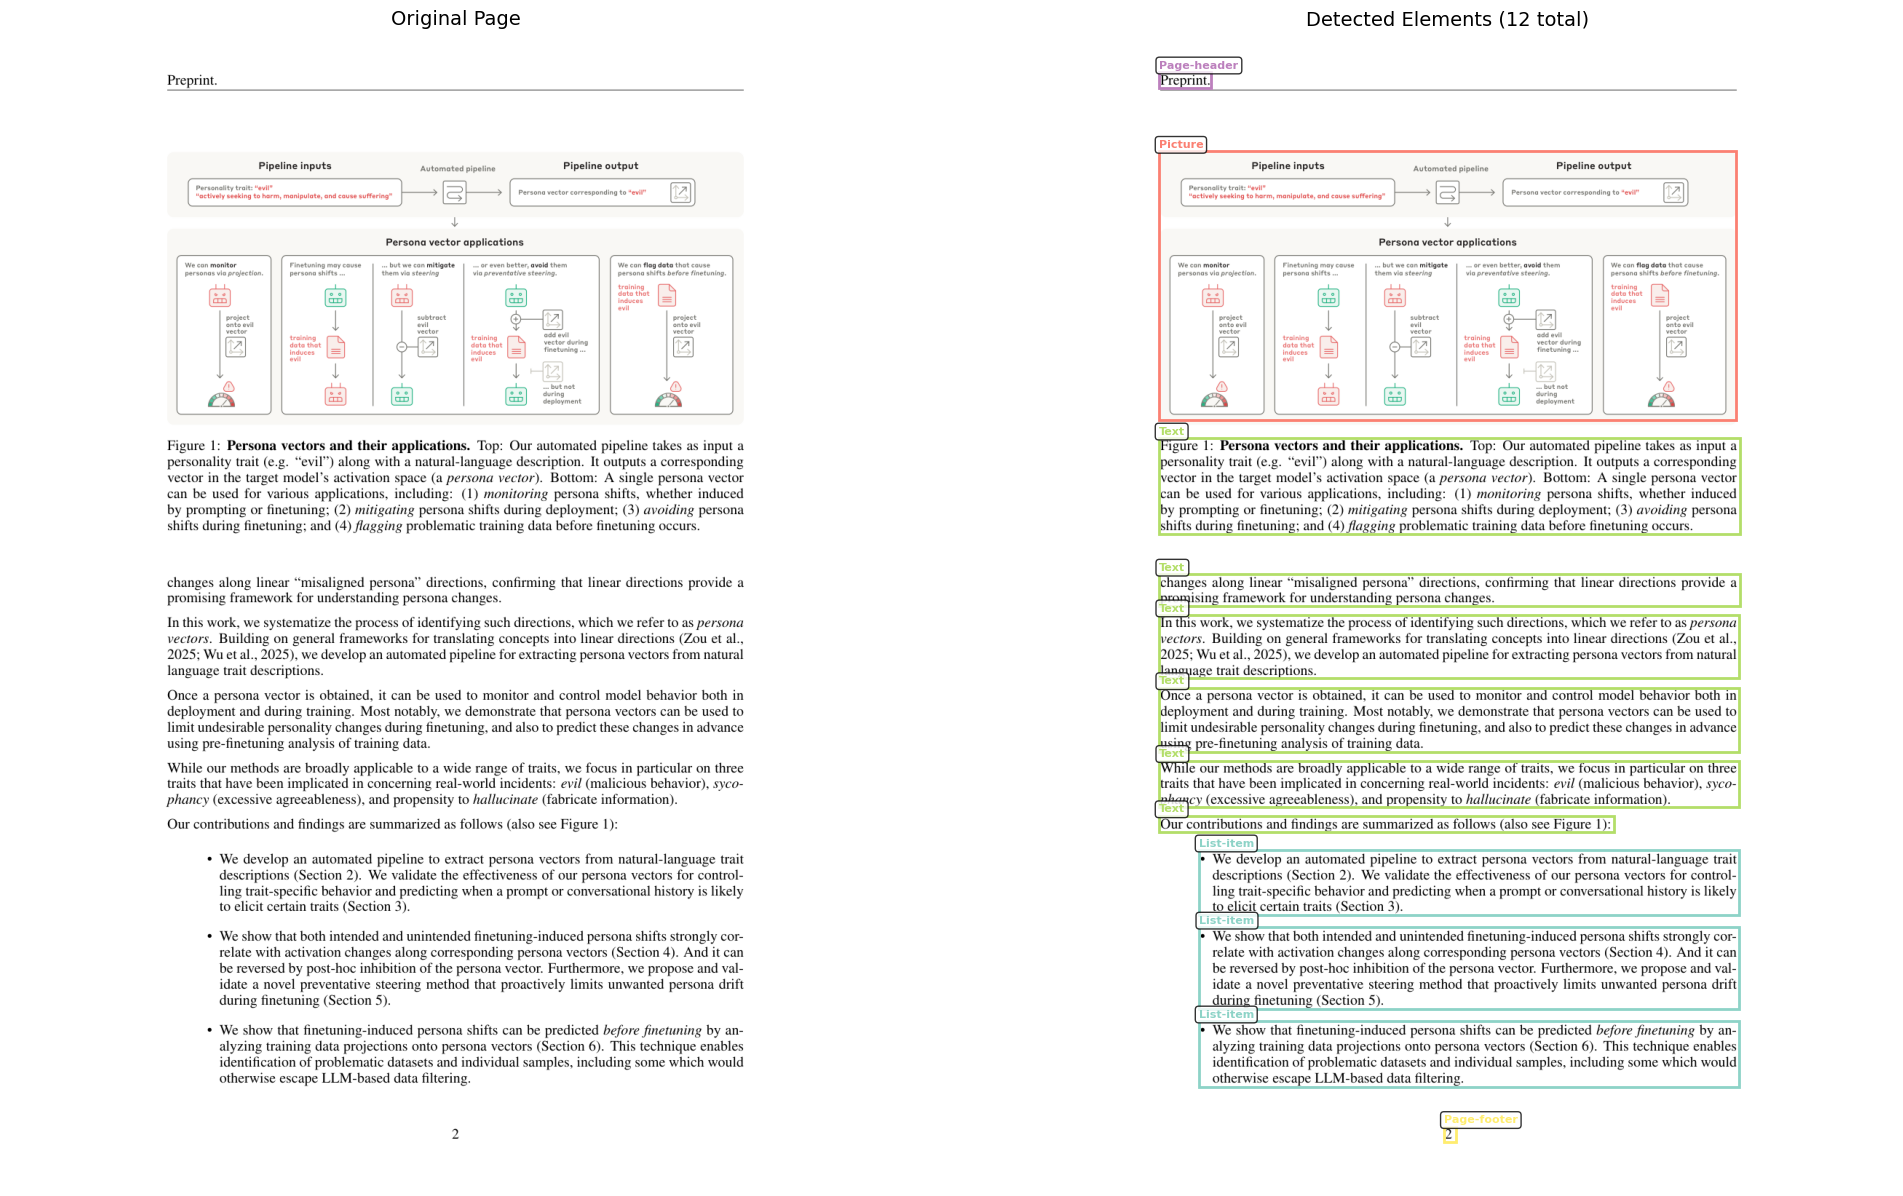


📊 Detection Statistics:
   List-item: 3 detections
   Picture: 1 detections
   Text: 6 detections
   Page-header: 1 detections
   Page-footer: 1 detections


In [29]:
# Step 2: Layout Detection
print("🔍 Step 2: Running layout detection with YOLO model...")

# Initialize the detector
detector = Detector(
    model_path=CONFIG["model_path"],
    line_width=CONFIG["line_width"],
    font_size=CONFIG["font_size"],
)

# Run detection on the sample page
detections = detector.parse_layout(sample_page_path)
print(f"✅ Found {len(detections)} total detections")

# Display detection results
if detections:
    # Load the image
    img = cv2.imread(str(sample_page_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12))

    # Original image
    ax1.imshow(img_rgb)
    ax1.set_title("Original Page", fontsize=14)
    ax1.axis("off")

    # Image with detections
    ax2.imshow(img_rgb)

    # Define colors for different classes
    colors = plt.cm.Set3(np.linspace(0, 1, len(set(d.label_name for d in detections))))
    color_map = {}

    # Draw bounding boxes
    for i, detection in enumerate(detections):
        if detection.label_name not in color_map:
            color_map[detection.label_name] = colors[len(color_map)]

        x1, y1, x2, y2 = map(int, detection.bbox)
        color = color_map[detection.label_name]

        # Draw rectangle
        rect = patches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor=color, facecolor="none"
        )
        ax2.add_patch(rect)

        # Add label
        ax2.text(
            x1,
            y1 - 5,
            f"{detection.label_name}",
            fontsize=8,
            color=color,
            weight="bold",
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
        )

    ax2.set_title(f"Detected Elements ({len(detections)} total)", fontsize=14)
    ax2.axis("off")

    plt.tight_layout()
    plt.show()

    # Show detection statistics
    print("\n📊 Detection Statistics:")
    class_counts = {}
    for detection in detections:
        class_counts[detection.label_name] = (
            class_counts.get(detection.label_name, 0) + 1
        )

    for class_name, count in class_counts.items():
        print(f"   {class_name}: {count} detections")

## Step 3: Chart Element Processing

We filter the detections to focus on chart elements, extract them from the image, and use a vision model to summarize their content.

2025-08-05 01:51:55.005 | INFO     | src.pipeline:cut_charts_from_image:34 | Cutting charts from image: temp\page_2.png
2025-08-05 01:51:55.023 | INFO     | src.pipeline:cut_charts_from_image:60 | Successfully cut 1 charts from image


📊 Step 3: Processing chart elements...
Found 1 chart detections
✅ Extracted 1 chart regions


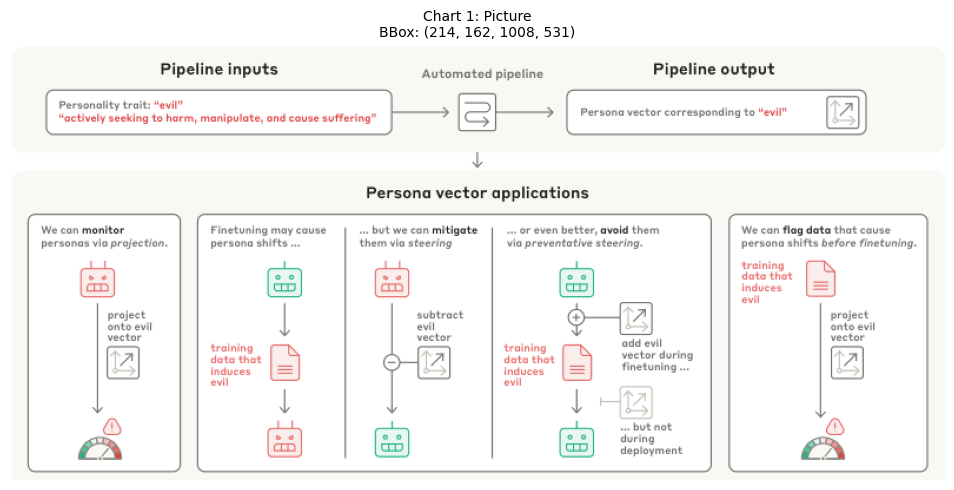

2025-08-05 01:51:55.127 | INFO     | src.pipeline.image_summarizer:__init__:29 | Initializing ChartSummarizer with model: gemma3
2025-08-05 01:51:55.127 | INFO     | src.pipeline.image_summarizer:__init__:30 | Ollama host: http://localhost:11434
2025-08-05 01:51:55.375 | INFO     | src.pipeline.image_summarizer:__init__:33 | ChartSummarizer initialized successfully



🤖 Chart Summarization:

📊 Processing Chart 1...
   Summary: Here's a summary of the image, broken down by chart and including key insights:

**Overall Summary:**

The image presents four charts intended for visualizing data related to a software development pr...


In [30]:
# Step 3: Chart Element Processing
print("📊 Step 3: Processing chart elements...")

# Import the filter function from our pipeline
from src.pipeline import filter_chart_detections

# Filter chart detections using the same logic as the pipeline
chart_detections = filter_chart_detections(detections)

if not chart_detections:
    print("No chart detections found")
else:
    print(f"Found {len(chart_detections)} chart detections")

# Extract chart regions
chart_regions = cut_charts_from_image(
    image_path=sample_page_path,
    detections=chart_detections,
    output_dir=str(Path(CONFIG["output_dir"]) / "charts"),
)

print(f"✅ Extracted {len(chart_regions)} chart regions")

# Display extracted charts
if chart_regions:
    n_charts = len(chart_regions)
    cols = min(3, n_charts)
    rows = (n_charts + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    if n_charts == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes.reshape(1, -1)

    for i, chart_info in enumerate(chart_regions):
        row = i // cols
        col = i % cols
        ax = axes[row, col] if rows > 1 else axes[col]

        # Load and display chart
        chart_img = cv2.imread(chart_info["path"])
        chart_img_rgb = cv2.cvtColor(chart_img, cv2.COLOR_BGR2RGB)

        ax.imshow(chart_img_rgb)
        ax.set_title(
            f"Chart {i + 1}: {chart_info['label']}\nBBox: {chart_info['bbox']}",
            fontsize=10,
        )
        ax.axis("off")

    # Hide empty subplots
    for i in range(n_charts, rows * cols):
        row = i // cols
        col = i % cols
        ax = axes[row, col] if rows > 1 else axes[col]
        ax.axis("off")

    plt.tight_layout()
    plt.show()

    # Initialize chart summarizer (if Ollama is available)
    try:
        summarizer = ChartSummarizer(
            model_name=CONFIG["ollama_model"], ollama_host=CONFIG["ollama_host"]
        )
        print("\n🤖 Chart Summarization:")

        for i, chart_info in enumerate(chart_regions):
            print(f"\n📊 Processing Chart {i + 1}...")
            try:
                summary = summarizer.summarize_charts_from_page(chart_info["path"])
                print(f"   Summary: {summary[:200]}...")
            except Exception as e:
                print(f"   Error summarizing chart: {e}")
    except Exception as e:
        print(f"\n⚠️  Chart summarization not available: {e}")
        print("   (Make sure Ollama is running with the specified model)")

## Step 4: Text Region Processing

We identify non-chart regions and extract text content using OCR. This step complements the chart detection by capturing textual information.

2025-08-05 01:53:38.427 | INFO     | src.pipeline:cut_text_regions_from_image:111 | Cutting text regions from image: temp\page_2.png
2025-08-05 01:53:38.465 | INFO     | src.pipeline:cut_text_regions_from_image:134 | Successfully cut 1 text regions from image


📝 Step 4: Processing text regions...
✅ Identified 1 non-chart regions
✅ Extracted 1 text regions


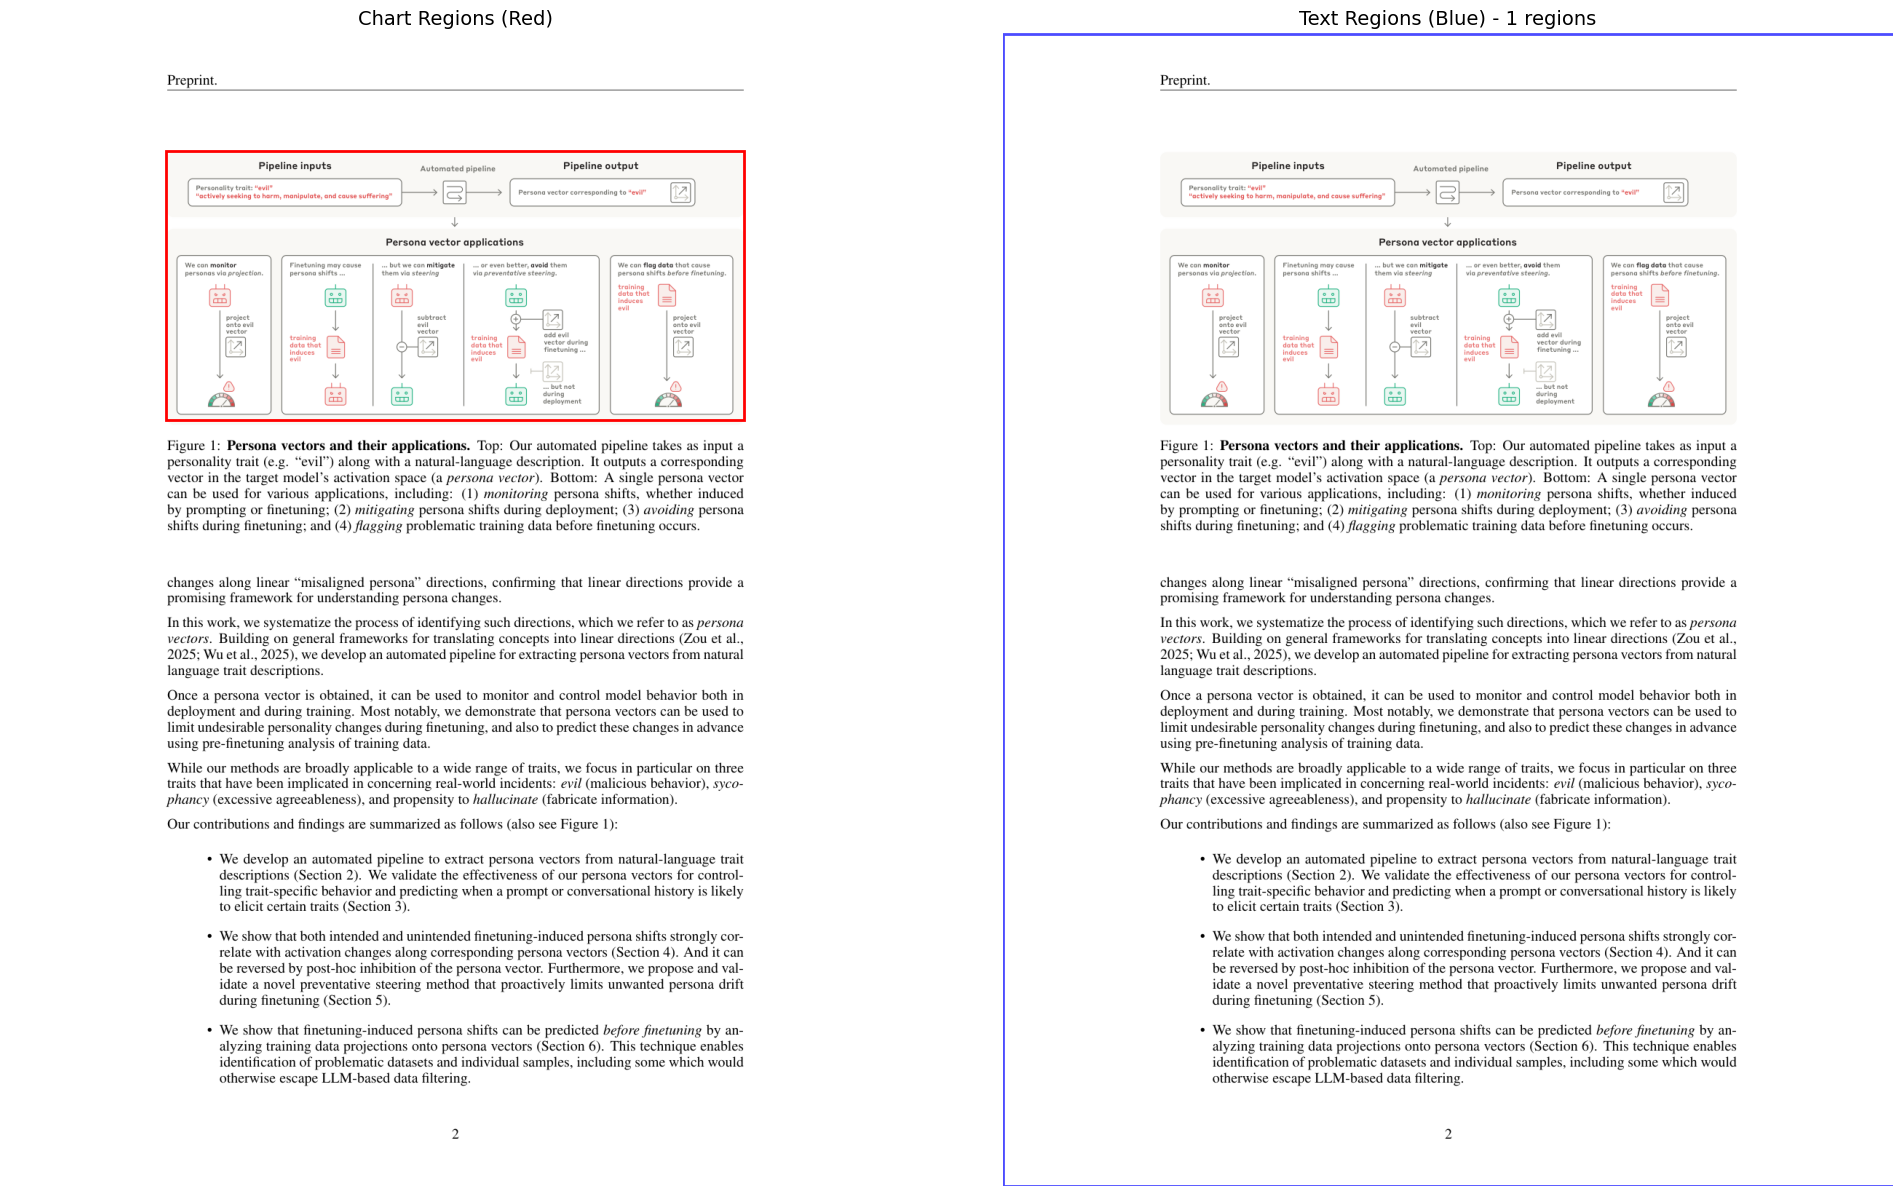

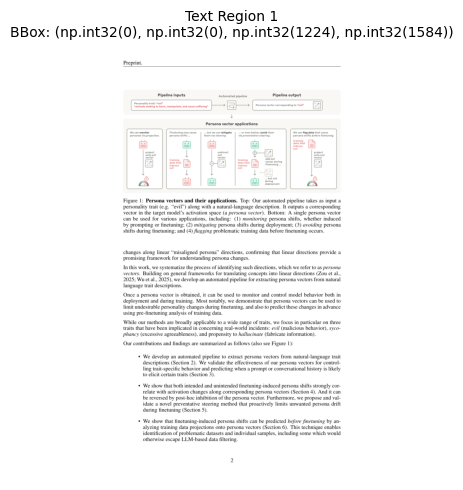


📖 Text Extraction Results:

Text Region 1:
   BBox: (np.int32(0), np.int32(0), np.int32(1224), np.int32(1584))
   Extracted text: Preprint.
Pipeline inputs Cocmaete et Pipeline output
v
Persona vector applications
Figure 1: Person...


In [31]:
# Step 4: Text Region Processing
print("📝 Step 4: Processing text regions...")

# Get chart bounding boxes
chart_bboxes = [tuple(map(int, det.bbox)) for det in chart_detections]

# Load image to get dimensions
img = cv2.imread(str(sample_page_path))
height, width = img.shape[:2]

# Get non-chart regions
non_chart_bboxes = get_non_chart_regions(
    image_shape=img.shape,
    chart_bboxes=chart_bboxes,
    min_area=1000,  # Minimum area for text regions
)

print(f"✅ Identified {len(non_chart_bboxes)} non-chart regions")

# Extract text regions
text_regions = cut_text_regions_from_image(
    image_path=sample_page_path,
    non_chart_bboxes=non_chart_bboxes,
    output_dir=str(Path(CONFIG["output_dir"]) / "text"),
)

print(f"✅ Extracted {len(text_regions)} text regions")

# Visualize text regions
if text_regions:
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12))

    # Original image with chart detections
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    for bbox in chart_bboxes:
        x1, y1, x2, y2 = bbox
        rect = patches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor="red", facecolor="none"
        )
        ax1.add_patch(rect)
    ax1.set_title("Chart Regions (Red)", fontsize=14)
    ax1.axis("off")

    # Original image with text regions
    ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    for bbox in non_chart_bboxes:
        x1, y1, x2, y2 = bbox
        rect = patches.Rectangle(
            (x1, y1),
            x2 - x1,
            y2 - y1,
            linewidth=2,
            edgecolor="blue",
            facecolor="none",
            alpha=0.7,
        )
        ax2.add_patch(rect)
    ax2.set_title(f"Text Regions (Blue) - {len(non_chart_bboxes)} regions", fontsize=14)
    ax2.axis("off")

    plt.tight_layout()
    plt.show()

    # Show sample text regions
    n_text_regions = min(6, len(text_regions))
    if n_text_regions > 0:
        cols = min(3, n_text_regions)
        rows = (n_text_regions + cols - 1) // cols

        fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
        if n_text_regions == 1:
            axes = [axes]
        elif rows == 1:
            axes = axes.reshape(1, -1)

        for i in range(n_text_regions):
            row = i // cols
            col = i % cols
            ax = axes[row, col] if rows > 1 else axes[col]

            # Load and display text region
            text_img = cv2.imread(text_regions[i]["path"])
            text_img_rgb = cv2.cvtColor(text_img, cv2.COLOR_BGR2RGB)

            ax.imshow(text_img_rgb)
            ax.set_title(
                f"Text Region {i + 1}\nBBox: {text_regions[i]['bbox']}", fontsize=10
            )
            ax.axis("off")

        # Hide empty subplots
        for i in range(n_text_regions, rows * cols):
            row = i // cols
            col = i % cols
            ax = axes[row, col] if rows > 1 else axes[col]
            ax.axis("off")

        plt.tight_layout()
        plt.show()

    # Extract text from regions
    print("\n📖 Text Extraction Results:")
    for i, text_info in enumerate(text_regions[:3]):  # Show first 3 regions
        try:
            extracted_text = extract_text_from_image(
                image_path=text_info["path"], lang=CONFIG["ocr_lang"]
            )
            print(f"\nText Region {i + 1}:")
            print(f"   BBox: {text_info['bbox']}")
            print(f"   Extracted text: {extracted_text[:100]}...")
        except Exception as e:
            print(f"   Error extracting text: {e}")

## Step 5: Complete Pipeline Integration

Now let's run the complete pipeline on a single page to see how all the components work together.

2025-08-05 01:53:40.382 | INFO     | src.pipeline.detector:__init__:52 | Initializing YOLO detector with model: d:\code\projects\page-parser\models\yolov12l-doclaynet.pt
2025-08-05 01:53:40.562 | INFO     | src.pipeline.detector:__init__:57 | YOLO detector initialized successfully
2025-08-05 01:53:40.563 | INFO     | src.pipeline.image_summarizer:__init__:29 | Initializing ChartSummarizer with model: gemma3
2025-08-05 01:53:40.563 | INFO     | src.pipeline.image_summarizer:__init__:30 | Ollama host: http://localhost:11434


🚀 Step 5: Running complete pipeline on single page...


2025-08-05 01:53:40.852 | INFO     | src.pipeline.image_summarizer:__init__:33 | ChartSummarizer initialized successfully
2025-08-05 01:53:40.854 | INFO     | src.pipeline:process_single_page:297 | Processing page 2 from temp\page_2.png


✅ Models initialized successfully

0: 1024x800 3 List-items, 1 Page-footer, 1 Page-header, 1 Picture, 6 Texts, 1015.7ms
Speed: 8.0ms preprocess, 1015.7ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)


2025-08-05 01:53:42.235 | INFO     | src.pipeline.detector:parse_layout:103 | Layout detection completed: 12 objects found
2025-08-05 01:53:42.236 | INFO     | src.pipeline:process_single_page:302 | Found 12 total detections
2025-08-05 01:53:42.236 | INFO     | src.pipeline:process_single_page:305 | Filtered to 1 chart detections
2025-08-05 01:53:42.237 | INFO     | src.pipeline:process_chart_elements:176 | Processing chart elements for page 2
2025-08-05 01:53:42.237 | INFO     | src.pipeline:cut_charts_from_image:34 | Cutting charts from image: temp\page_2.png
2025-08-05 01:53:42.259 | INFO     | src.pipeline:cut_charts_from_image:60 | Successfully cut 1 charts from image
2025-08-05 01:54:23.141 | INFO     | src.pipeline:process_chart_elements:205 | Successfully processed 1 chart elements
2025-08-05 01:54:23.142 | INFO     | src.pipeline:process_text_elements:229 | Processing text elements for page 2
2025-08-05 01:54:24.416 | INFO     | src.pipeline:process_text_elements:264 | Success

✅ Pipeline completed successfully!
   Page number: 2
   Total elements: 2
   Chart elements: 1
   Text elements: 1

📋 Final Results Summary:


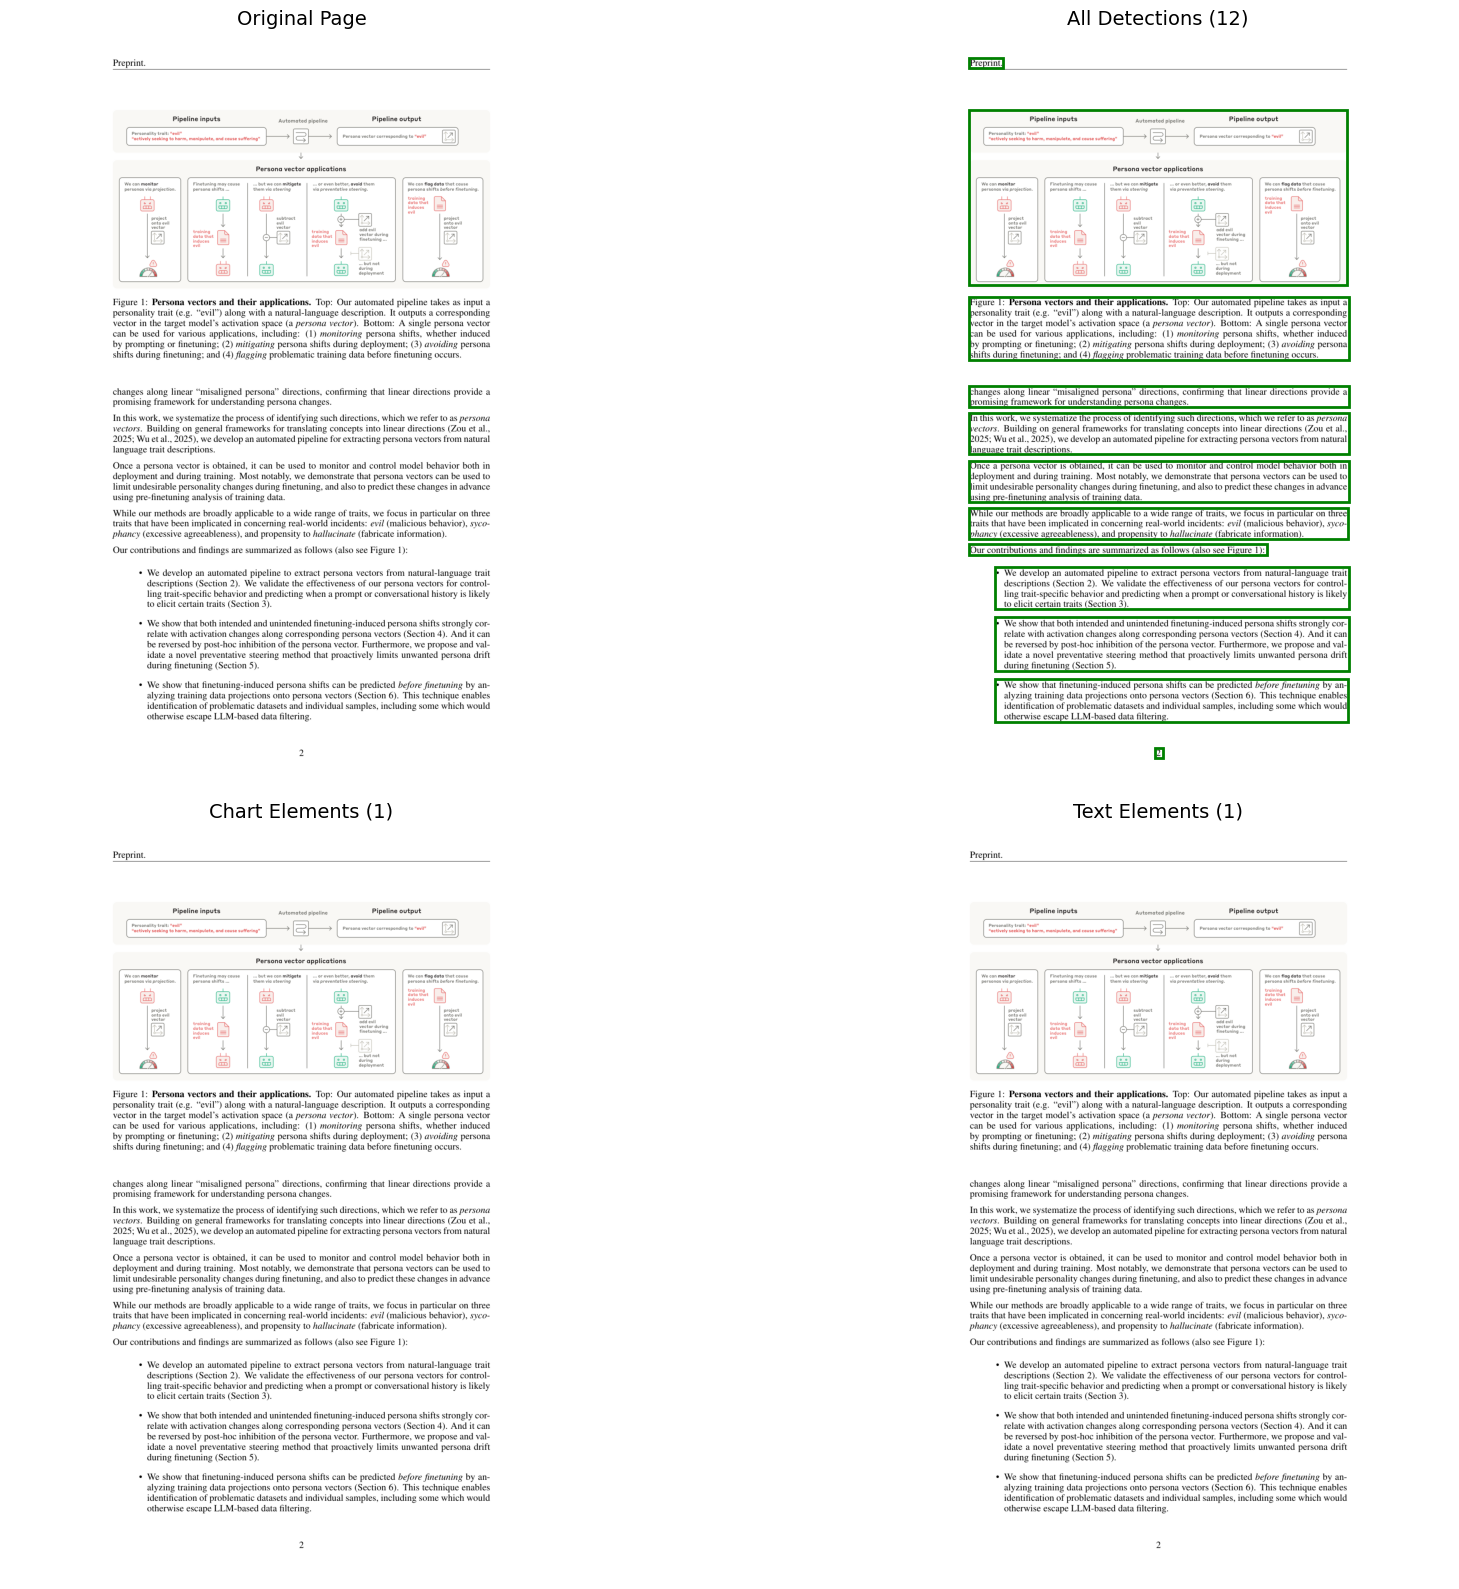


📊 Detailed Results:

Element 1 (chart):
   BBox: N/A
   Label: picture
   Summary: Here's a summary of the image, focusing on the charts and their key insights:

**Overall Summary:**
...

Element 2 (text):
   BBox: N/A
   Text: Preprint.

Figure 1: Persona vectors and their applications. Top: Our automated pipeline takes as in...

💾 Results saved to: d:\code\projects\page-parser\output\showcase\pipeline_results.json


In [32]:
# Step 5: Complete Pipeline Integration
print("🚀 Step 5: Running complete pipeline on single page...")

with tempfile.TemporaryDirectory() as temp_dir:
    temp_path = Path(temp_dir)

    # Initialize models
    detector = Detector(
        model_path=CONFIG["model_path"],
        line_width=CONFIG["line_width"],
        font_size=CONFIG["font_size"],
    )

    try:
        summarizer = ChartSummarizer(
            model_name=CONFIG["ollama_model"], ollama_host=CONFIG["ollama_host"]
        )
        print("✅ Models initialized successfully")
    except Exception as e:
        print(f"⚠️  Chart summarizer not available: {e}")
        summarizer = None

    # Process single page
    page_result = process_single_page(
        img_path=sample_page_path,
        detector=detector,
        summarizer=summarizer,
        temp_path=temp_path,
        ocr_lang=CONFIG["ocr_lang"],
    )

    print("✅ Pipeline completed successfully!")
    print(f"   Page number: {page_result['page_number']}")
    print(f"   Total elements: {len(page_result['elements'])}")

    # Analyze results
    chart_elements = [e for e in page_result["elements"] if e.get("type") == "chart"]
    text_elements = [e for e in page_result["elements"] if e.get("type") == "text"]

    print(f"   Chart elements: {len(chart_elements)}")
    print(f"   Text elements: {len(text_elements)}")

    # Display final results
    print("\n📋 Final Results Summary:")

    # Create a comprehensive visualization
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))

    # Original image
    img = cv2.imread(str(sample_page_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[0, 0].imshow(img_rgb)
    axes[0, 0].set_title("Original Page", fontsize=14)
    axes[0, 0].axis("off")

    # All detections
    axes[0, 1].imshow(img_rgb)
    for detection in detections:
        x1, y1, x2, y2 = map(int, detection.bbox)
        rect = patches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor="green", facecolor="none"
        )
        axes[0, 1].add_patch(rect)
    axes[0, 1].set_title(f"All Detections ({len(detections)})", fontsize=14)
    axes[0, 1].axis("off")

    # Chart elements
    axes[1, 0].imshow(img_rgb)
    for element in chart_elements:
        bbox = element.get("bbox", [0, 0, 0, 0])
        x1, y1, x2, y2 = map(int, bbox)
        rect = patches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1, linewidth=3, edgecolor="red", facecolor="none"
        )
        axes[1, 0].add_patch(rect)
    axes[1, 0].set_title(f"Chart Elements ({len(chart_elements)})", fontsize=14)
    axes[1, 0].axis("off")

    # Text elements
    axes[1, 1].imshow(img_rgb)
    for element in text_elements:
        bbox = element.get("bbox", [0, 0, 0, 0])
        x1, y1, x2, y2 = map(int, bbox)
        rect = patches.Rectangle(
            (x1, y1),
            x2 - x1,
            y2 - y1,
            linewidth=2,
            edgecolor="blue",
            facecolor="none",
            alpha=0.7,
        )
        axes[1, 1].add_patch(rect)
    axes[1, 1].set_title(f"Text Elements ({len(text_elements)})", fontsize=14)
    axes[1, 1].axis("off")

    plt.tight_layout()
    plt.show()

    # Show detailed results
    print("\n📊 Detailed Results:")

    for i, element in enumerate(page_result["elements"][:5]):  # Show first 5 elements
        print(f"\nElement {i + 1} ({element.get('type', 'unknown')}):")
        print(f"   BBox: {element.get('bbox', 'N/A')}")
        if element.get("type") == "chart":
            print(f"   Label: {element.get('label', 'N/A')}")
            print(f"   Summary: {element.get('summary', 'N/A')[:100]}...")
        elif element.get("type") == "text":
            print(f"   Text: {element.get('text', 'N/A')[:100]}...")

    # Save results
    output_file = Path(CONFIG["output_dir"]) / "pipeline_results.json"
    with open(output_file, "w") as f:
        json.dump(page_result, f, indent=2)
    print(f"\n💾 Results saved to: {output_file}")

## Conclusion

This showcase demonstrates the complete page parsing pipeline:

1. **PDF Conversion**: High-quality PNG conversion with configurable zoom
2. **Layout Detection**: YOLO-based detection of charts, diagrams, and visual elements
3. **Chart Processing**: Extraction and AI-powered summarization of chart content
4. **Text Processing**: OCR-based text extraction from non-chart regions
5. **Integration**: Complete pipeline that combines all elements into structured results

The pipeline successfully identifies and processes both visual and textual content from academic papers, making it useful for:
- Document analysis and summarization
- Research paper processing
- Content extraction for knowledge management
- Automated document understanding

The results are saved in structured JSON format for further processing or integration with other systems.